## 1 - Packages

Let's first import all the packages that you will need during this assignment. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- dnn_utils provides some necessary functions for this notebook.
- testCases provides some test cases to assess the correctness of your functions
- np.random.seed(1) is used to keep all the random function calls consistent. It will help us grade your work. Please don't change the seed. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import h5py
import math
import matplotlib.pyplot as plt
import scipy

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("scipy version: {}".format(scipy.__version__))   

C:\Users\edh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\edh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\edh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\edh\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type

TensorFlow version: 1.14.0
Eager execution: False
scipy version: 1.4.1


## 2 - Outline of the Assignment

To build your neural network, you will be implementing several "helper functions". These helper functions will be used in the next assignment to build a two-layer neural network and an L-layer neural network. Each small helper function you will implement will have detailed instructions that will walk you through the necessary steps. Here is an outline of this assignment, you will:

- Initialize the parameters for a two-layer network and for an $L$-layer neural network.
- Implement the forward propagation module (shown in purple in the figure below).
     - Complete the LINEAR part of a layer's forward propagation step (resulting in $Z^{[l]}$).
     - We give you the ACTIVATION function (relu/sigmoid).
     - Combine the previous two steps into a new [LINEAR->ACTIVATION] forward function.
     - Stack the [LINEAR->RELU] forward function L-1 time (for layers 1 through L-1) and add a [LINEAR->SIGMOID] at the end (for the final layer $L$). This gives you a new L_model_forward function.
- Compute the loss.
- Implement the backward propagation module (denoted in red in the figure below).
    - Complete the LINEAR part of a layer's backward propagation step.
    - We give you the gradient of the ACTIVATE function (relu_backward/sigmoid_backward) 
    - Combine the previous two steps into a new [LINEAR->ACTIVATION] backward function.
    - Stack [LINEAR->RELU] backward L-1 times and add [LINEAR->SIGMOID] backward in a new L_model_backward function
- Finally update the parameters.

<img src="images/final outline.png" style="width:800px;height:500px;">
<caption><center> **Figure 1**</center></caption><br>


**Note** that for every forward function, there is a corresponding backward function. That is why at every step of your forward module you will be storing some values in a cache. The cached values are useful for computing gradients. In the backpropagation module you will then use the cache to calculate the gradients. This assignment will show you exactly how to carry out each of these steps. 

In [3]:
def init_xavier(fan_in, fan_out):
    
    
    low = -1*np.sqrt(6.0/(fan_in + fan_out)) # use 4 for sigmoid, 1 for tanh activation 
    high = 1*np.sqrt(6.0/(fan_in + fan_out))
    print (low)
    print (high)
    
    
    return tf.Variable(tf.random.uniform(shape=[fan_in,fan_out], minval=low, maxval=high, dtype=tf.float64))

In [4]:
tf.random.set_seed(1)
E_test = init_xavier(7,3)
print(E_test)
E_test = init_xavier(7, 3)
print(E_test)

-0.7745966692414834
0.7745966692414834
<tf.Variable 'Variable:0' shape=(7, 3) dtype=float64, numpy=
array([[-0.27723213, -0.70055522, -0.25482261],
       [ 0.47449356, -0.33955955, -0.63044009],
       [-0.59693595, -0.3783119 ,  0.04182916],
       [-0.63550074, -0.31254426,  0.10650895],
       [-0.75993902,  0.42112937, -0.67539809],
       [-0.34067297,  0.73040923, -0.26109316],
       [-0.24811073, -0.22055695,  0.3544005 ]])>
-0.7745966692414834
0.7745966692414834
<tf.Variable 'Variable:0' shape=(7, 3) dtype=float64, numpy=
array([[-0.64933453, -0.3590024 ,  0.0144264 ],
       [-0.01775873,  0.23701789,  0.00616325],
       [-0.16836257, -0.40409459, -0.70133351],
       [-0.37474255, -0.23009522,  0.58542425],
       [-0.01942412, -0.22070218,  0.47835642],
       [ 0.60011379, -0.38831085, -0.09837197],
       [ 0.56808128, -0.14084823, -0.66869935]])>


In [5]:

def initialize_parameters(L, layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    tf.random.set_seed(1)
    parameters = {}
    p = {}
    listp = []  
    
    for l in range(1, L+1):       
        #initializer = tf.initializers.GlorotUniform(seed)
        #parameters['W' + str(l)]  = tf.Variable(initializer(shape=(layer_dims[l], layer_dims[l-1]), dtype=tf.dtypes.float64))
        #parameters['W' + str(l)]  = init_xavier(layer_dims[l], layer_dims[l-1])
        #parameters['W' + str(l)]  = tf.Variable(tf.random.uniform(shape=[layer_dims[l], layer_dims[l-1]], dtype=tf.float64))
        parameters['W' + str(l)]  = tf.Variable(tf.zeros(shape=([layer_dims[l], layer_dims[l-1]]), dtype=tf.dtypes.float64))
        parameters['b' + str(l)]  = tf.Variable(tf.zeros(shape=([layer_dims[l], 1]), dtype=tf.dtypes.float64))

        print ("Init")
        print(parameters['W' + str(l)].shape)
        print(parameters['b' + str(l)].shape)

    p['W1'] = np.load("save_parameters_W1.npy")
    p['W2'] = np.load("save_parameters_W2.npy")
    p['W3'] = np.load("save_parameters_W3.npy")
    p['W4'] = np.load("save_parameters_W4.npy")
    
    
    parameters['W1'].assign(p['W1'])
    parameters['W2'].assign(p['W2'])
    parameters['W3'].assign(p['W3'])
    parameters['W4'].assign(p['W4'])                                            

    for l in range(1, L+1): 
            listp.append(parameters["W"+str(l)])
            listp.append(parameters["b"+str(l)])
    
    return listp

In [6]:
listp_test = initialize_parameters(4, [12288, 20, 7, 5, 1])
print(listp_test)

Init
(20, 12288)
(20, 1)
Init
(7, 20)
(7, 1)
Init
(5, 7)
(5, 1)
Init
(1, 5)
(1, 1)
[<tf.Variable 'Variable:0' shape=(20, 12288) dtype=float64, numpy=
array([[ 0.02928294, -0.01102846, -0.00952163, ..., -0.00950437,
        -0.00685659,  0.01711556],
       [ 0.01819395,  0.00414433, -0.01197207, ...,  0.01243645,
        -0.00880324,  0.00374269],
       [-0.00642393, -0.00352404,  0.01147998, ...,  0.01483218,
        -0.00188253, -0.01186134],
       ...,
       [ 0.00315022, -0.0023465 ,  0.03309543, ..., -0.0166323 ,
        -0.01486895, -0.00276461],
       [-0.00063006, -0.00751781, -0.0154166 , ...,  0.04051383,
        -0.00962016, -0.00053279],
       [-0.02585687, -0.02002211,  0.01309371, ...,  0.03963587,
         0.02772981,  0.01345943]])>, <tf.Variable 'Variable:0' shape=(20, 1) dtype=float64, numpy=
array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
    

# 4 - Forward propagation module

### 4.1 - Linear-Activation Forward 
Now that you have initialized your parameters, you will do the forward propagation module.

The linear forward module (vectorized over all the examples) computes the following equations:

$$Z^{[l]} = W^{[l]}A^{[l-1]} +b^{[l]}\tag{4}$$

where $A^{[0]} = X$. 


We use two activation functions:

- **Sigmoid**: $\sigma(Z) = \sigma(W A + b) = \frac{1}{ 1 + e^{-(W A + b)}}$. We have provided you with the `sigmoid` function. This function returns **two** items: the activation value "`a`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call: 
``` python
A, activation_cache = sigmoid(Z)
```

- **ReLU**: The mathematical formula for ReLu is $A = RELU(Z) = max(0, Z)$. We have provided you with the `relu` function. This function returns **two** items: the activation value "`A`" and a "`cache`" that contains "`Z`" (it's what we will feed in to the corresponding backward function). To use it you could just call:
``` python
A, activation_cache = relu(Z)
```

In [7]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward_tf(A_prev, W, b):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
    b -- bias vector, numpy array of shape (size of the current layer, 1)
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- a python tuple containing "linear_cache" and "activation_cache";
             stored for computing the backward pass efficiently
    """

    Z = tf.add (tf.matmul(W,A_prev),b) 
    A = tf.nn.relu(Z)  

    return A

In [22]:
R_test = tf.constant([[-0.02602383, 4.01, 4.85, 7.32], [-0.02178065, 9.1,5.45,6.41],  [-0.026, 9.1,5.45,6.41], [-0.03539175, 7.12, 0.,5.1], [-0.03269102, 7.12, 0.,5.1], [-0.02149617, 7.12, 0.,5.1], [-0.04413767, 7.12, 0.,5.1]])
W_test = tf.constant([[-0.029, 4.01, 4.85, 7.32, 2.3, 4.5, 1.], [-0.02602383, 4.01, 4.85, 7.32, 2.3, 4.5, 1.], [-0.02178065, 9.1,5.45,6.41, 2.3, 4.5, 1.],  [-0.03539175, 7.12, 0.,5.1, 2.3, 4.5,1.], [-0.03269102, 7.12, 0.,5.1, 2.3, 4.5,1.], [-0.03769102, 7.12, 0.,5.1, 2.3, 4.5,1.]])
b_test = tf.constant([[-1.0], [-1.0], [-1.0],  [-1.0], [-1.0], [-1.0]])

print(W_test)
print(R_test)
print(b_test)
print("mul:" ,tf.matmul(W_test,R_test))
Z_test      = tf.add (tf.matmul(W_test,R_test),b_test) 
print(Z_test)
Z_test      = linear_activation_forward_tf(R_test, W_test, b_test)
print(Z_test)

tf.Tensor(
[[-0.029       4.01        4.85        7.32        2.3         4.5
   1.        ]
 [-0.02602383  4.01        4.85        7.32        2.3         4.5
   1.        ]
 [-0.02178065  9.1         5.45        6.41        2.3         4.5
   1.        ]
 [-0.03539175  7.12        0.          5.1         2.3         4.5
   1.        ]
 [-0.03269102  7.12        0.          5.1         2.3         4.5
   1.        ]
 [-0.03769102  7.12        0.          5.1         2.3         4.5
   1.        ]], shape=(6, 7), dtype=float32)
tf.Tensor(
[[-0.02602383  4.01        4.85        7.32      ]
 [-0.02178065  9.1         5.45        6.41      ]
 [-0.026       9.1         5.45        6.41      ]
 [-0.03539175  7.12        0.          5.1       ]
 [-0.03269102  7.12        0.          5.1       ]
 [-0.02149617  7.12        0.          5.1       ]
 [-0.04413767  7.12        0.          5.1       ]], shape=(7, 4), dtype=float32)
tf.Tensor(
[[-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]
 [-1.]], shape=(6, 1)

In [23]:
a = tf.constant([1, 1, 1, 1, 1, 1], shape=[2, 3])  # 2-D tensor
b = tf.constant([2, 4, 6, 10, 100, 1000], shape=[3, 2])  # 2-D tensor
c = tf.matmul(a, b)  # a * b
print (a,b,c)

tf.Tensor(
[[1 1 1]
 [1 1 1]], shape=(2, 3), dtype=int32) tf.Tensor(
[[   2    4]
 [   6   10]
 [ 100 1000]], shape=(3, 2), dtype=int32) tf.Tensor(
[[ 108 1014]
 [ 108 1014]], shape=(2, 2), dtype=int32)


### d) L-Layer Model 

For even more convenience when implementing the $L$-layer Neural Net, you will need a function that replicates the previous one (`linear_activation_forward` with RELU) $L-1$ times, then follows that with one `linear_activation_forward` with SIGMOID.

<img src="images/model_architecture_kiank.png" style="width:600px;height:300px;">
<caption><center> **Figure 2** : *[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID* model</center></caption><br>


In [24]:
def L_model_forward_list(L, X, listp):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters_deep()
    
    Returns:
    AL -- last post-activation value
    caches -- list of caches containing:
                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
    """
   
    A = X

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    i = 0
    for l in range(1, L):
        A_prev = A 

        A = linear_activation_forward_tf(A_prev, listp[i], listp[i+1])
        i = i+2
     
    ZL = tf.add (tf.matmul(listp[i], A), listp[i+1])
    
    if ZL.shape[0] == 1:
        AL = tf.math.sigmoid(ZL)
    else:    
        AL = tf.nn.softmax(ZL, axis= 0)


    return AL

In [25]:
Z_test = tf.constant([[0., 4.01, 4.85, 7.32], [1., 9.1,5.45,6.41],  [0.23682965, 7.12, 0.,5.1], [5.5, 7.12, 0.,5.1], [-5.2, 7.12, 0.,5.1], [4.9, 7.12, 0.,5.1]],dtype=tf.float64)
print(Z_test)
S_test = tf.math.sigmoid(Z_test)
print(S_test)
S_test = 1./(1. + np.exp(-Z_test))
print(S_test)

tf.Tensor(
[[ 0.          4.01        4.85        7.32      ]
 [ 1.          9.1         5.45        6.41      ]
 [ 0.23682965  7.12        0.          5.1       ]
 [ 5.5         7.12        0.          5.1       ]
 [-5.2         7.12        0.          5.1       ]
 [ 4.9         7.12        0.          5.1       ]], shape=(6, 4), dtype=float64)
tf.Tensor(
[[0.5        0.98218957 0.99223243 0.99933828]
 [0.73105858 0.99988835 0.99572207 0.99835768]
 [0.55893222 0.99919189 0.5        0.9939402 ]
 [0.99592986 0.99919189 0.5        0.9939402 ]
 [0.0054863  0.99919189 0.5        0.9939402 ]
 [0.99260846 0.99919189 0.5        0.9939402 ]], shape=(6, 4), dtype=float64)
[[0.5        0.98218957 0.99223243 0.99933828]
 [0.73105858 0.99988835 0.99572207 0.99835768]
 [0.55893222 0.99919189 0.5        0.9939402 ]
 [0.99592986 0.99919189 0.5        0.9939402 ]
 [0.0054863  0.99919189 0.5        0.9939402 ]
 [0.99260846 0.99919189 0.5        0.9939402 ]]


In [26]:
Z_test = tf.constant([[3.2, 4.01, 4.85, 7.32], [3.63, 9.1,5.45,6.41],  [4.2, 7.12, 0.,5.1], [5.5, 7.12, 0.,5.1], [5.2, 7.12, 0.,5.1], [4.9, 7.12, 0.,5.1]])
R_test = tf.constant([[-0.02602383, 4.01, 4.85, 7.32], [-0.02178065, 9.1,5.45,6.41],  [-0.03539175, 7.12, 0.,5.1], [-0.03269102, 7.12, 0.,5.1], [-0.02149617, 7.12, 0.,5.1], [-0.04413767, 7.12, 0.,5.1]])

print(Z_test)

Al_test = tf.nn.softmax(Z_test, axis= 0)
print(Al_test)
print(tf.math.reduce_sum(Al_test,axis=0))
E_test = tf.math.exp(Z_test)

S_test = E_test/tf.math.reduce_sum(E_test,axis=0)

print(S_test)

tf.Tensor(
[[3.2  4.01 4.85 7.32]
 [3.63 9.1  5.45 6.41]
 [4.2  7.12 0.   5.1 ]
 [5.5  7.12 0.   5.1 ]
 [5.2  7.12 0.   5.1 ]
 [4.9  7.12 0.   5.1 ]], shape=(6, 4), dtype=float32)
tf.Tensor(
[[0.03559641 0.00395141 0.35045514 0.54437757]
 [0.05472085 0.6416695  0.63857085 0.21912508]
 [0.09676105 0.08859477 0.0027435  0.05912435]
 [0.35504505 0.08859477 0.0027435  0.05912435]
 [0.2630238  0.08859477 0.0027435  0.05912435]
 [0.19485287 0.08859477 0.0027435  0.05912435]], shape=(6, 4), dtype=float32)
tf.Tensor([1.        1.0000001 0.9999999 1.       ], shape=(4,), dtype=float32)
tf.Tensor(
[[0.03559641 0.00395141 0.35045516 0.5443775 ]
 [0.05472085 0.6416695  0.63857085 0.21912505]
 [0.09676104 0.08859478 0.0027435  0.05912434]
 [0.35504502 0.08859478 0.0027435  0.05912434]
 [0.2630238  0.08859478 0.0027435  0.05912434]
 [0.19485287 0.08859478 0.0027435  0.05912434]], shape=(6, 4), dtype=float32)


In [107]:
def compute_cost_tf(L, m, AL, Y, listp, lambd):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    Returns:
    cost -- cross-entropy cost
    """

    # Compute loss from aL and y. 
    cost = -tf.add (tf.math.multiply(Y, tf.math.log (abs(AL))), tf.math.multiply(1-Y, tf.math.log (abs(1-AL))))
    cost = tf.reduce_mean (cost)
    
    
    if lambd != 0:
        L2_regularization_cost = 0.
        i = 0
        for l in range(1, L+1):
            L2_regularization_cost = L2_regularization_cost + np.sum(np.square(listp[i]))
            i = i + 2
    
        cost = cost + (L2_regularization_cost * lambd / ( 2.0 * m))
    return cost

In [105]:
np.set_printoptions(precision=15)
A_test = tf.constant(([[1.145589], [3.56489],  [8.44566]]), dtype=tf.float64)
B_test = tf.constant(([[1.45789], [0.44577],  [0.84204]]), dtype=tf.float64)
print (A_test)
print (B_test)
K1_test = tf.math.multiply(B_test, tf.math.log (abs(A_test))) 
print (K1_test)
K2_test = tf.math.multiply(1.-B_test, tf.math.log (abs(1.-A_test)))
print (K2_test)
cost_test = -tf.add (K1_test,K2_test)
print (cost_test)
cost_test = -tf.add (tf.math.multiply(B_test, tf.math.log (abs(A_test))),tf.math.multiply(1-B_test, tf.math.log (abs(1-A_test))))
print (cost_test)
cost_test = tf.reduce_mean (cost_test)
print (cost_test)


tf.Tensor(
[[1.145589]
 [3.56489 ]
 [8.44566 ]], shape=(3, 1), dtype=float64)
tf.Tensor(
[[1.45789]
 [0.44577]
 [0.84204]], shape=(3, 1), dtype=float64)
tf.Tensor(
[[0.198154827314223]
 [0.566633045605704]
 [1.796620919473565]], shape=(3, 1), dtype=float64)
tf.Tensor(
[[0.882339238103532]
 [0.522037878949266]
 [0.317125442092096]], shape=(3, 1), dtype=float64)
tf.Tensor(
[[-1.080494065417755]
 [-1.08867092455497 ]
 [-2.113746361565661]], shape=(3, 1), dtype=float64)
tf.Tensor(
[[-1.080494065417755]
 [-1.08867092455497 ]
 [-2.113746361565661]], shape=(3, 1), dtype=float64)
tf.Tensor(-1.4276371171794622, shape=(), dtype=float64)


In [29]:
def my_loss(m, A, Y):
    
    lg = -tf.math.multiply(Y, tf.math.log (A))  
    j  = tf.math.reduce_sum(lg) / m
    
    return j

In [30]:
A_test = tf.constant([[1., 1., 4., 5.], [3., 9.,10.,10.],  [8., 9.,50.,10.]])
B_test = tf.constant([[1., 0., 1., 0.], [0., 1.,0.,0.],  [0., 0.,0.,1.]])
print (A_test)
print (B_test)
K_test = tf.math.multiply(A_test, B_test) 
print (K_test)
j_test =tf.math.reduce_sum(K_test,axis=0)/3
print (j_test)
j_test =tf.math.reduce_mean(K_test,axis=0)
print (j_test)
j_test =tf.math.reduce_sum(K_test,axis=1)/4
print (j_test)
j_test =tf.math.reduce_mean(K_test,axis=1)
print (j_test)
j_test =tf.math.reduce_sum(K_test)/4
print (j_test)
j_test = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = tf.transpose(A_test), labels = tf.transpose(B_test)))
print (j_test)

tf.Tensor(
[[ 1.  1.  4.  5.]
 [ 3.  9. 10. 10.]
 [ 8.  9. 50. 10.]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[1. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]], shape=(3, 4), dtype=float32)
tf.Tensor(
[[ 1.  0.  4.  0.]
 [ 0.  9.  0.  0.]
 [ 0.  0.  0. 10.]], shape=(3, 4), dtype=float32)
tf.Tensor([0.33333334 3.         1.3333334  3.3333333 ], shape=(4,), dtype=float32)
tf.Tensor([0.33333334 3.         1.3333334  3.3333333 ], shape=(4,), dtype=float32)
tf.Tensor([1.25 2.25 2.5 ], shape=(3,), dtype=float32)
tf.Tensor([1.25 2.25 2.5 ], shape=(3,), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(13.599361, shape=(), dtype=float32)


In [115]:
def random_mini_batches_new(X, Y, mini_batch_size = 32, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    if mini_batch_size == 0:
            mini_batch_size = m
            permutation= [i for i in range(m)]
    else:
            permutation = list(np.random.permutation(m))
   
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches


In [32]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

In [120]:
def model_tf(X, Y, layers_dims, learning_rate = 0.0075, num_epochs = 1500, minibatch_size = 32, print_cost = True, lambd = 0., ADAM = False):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    
    if ADAM:
        beta1 = 0.9
        beta2 = 0.999
        epsilon = 1e-4
    else:    
        beta1 = 0
        beta2 = 0
        epsilon = 0 
        
    print ("learning_rate:" + str(learning_rate)) 
    print ("minibatch_size:" + str(minibatch_size)) 
    print ("num_epochs:" + str(num_epochs)) 
    print ("lambd:" + str(lambd)) 
    #print ("keep_prob:" + str(keep_prob)) 
    print ("beta1:" + str(beta1)) 
    print ("beta2:" + str(beta2)) 
    print ("epsilon:" + str(epsilon))
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.random.set_seed(1)                             # to keep consistent results
    seed = 1                                          # to keep consistent results
    
    L = len(layers_dims) -1
    (n_x, m) = X.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y.shape[0]                            # n_y : output size

    print ("L:" + str(L))
    print ("m:" + str(m))
    print ("n_x:" + str(n_x))
    print ("n_y:" + str(n_y))
    
    costs = []
    
    # Initialize parameters
    listp = initialize_parameters(L, layers_dims)
    
    if ADAM:
        optimizer = tf.optimizers.Adam(learning_rate=learning_rate, beta_1=beta1, beta_2=beta2, epsilon=epsilon)
    else:   
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
       
    # Do the training loop
    for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            c = 0.
            seed = seed + 1
         
            # Define the random minibatches. We increment the seed to reshuffle differently the dataset after each epoch          
            minibatches = random_mini_batches_new(X, Y, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                mini_m = minibatch_X.shape[1]
                    
                with tf.GradientTape() as tape:
                     AL = L_model_forward_list(L, minibatch_X, listp)
                     #print ("AL: " +str(AL))                      
                     
                     loss_value= compute_cost_tf(L, mini_m, AL, minibatch_Y, listp, lambd)
                     print ("loss_value: " +str(loss_value)) 
                        
                grads = tape.gradient(loss_value, listp)
                #print ("grads: " +str(grads))
                grads_and_vars = zip(grads, listp)
                optimizer.apply_gradients(grads_and_vars)             
                
                epoch_cost += loss_value
                c = c + 1

            epoch_cost = epoch_cost / c
            
            # Print the cost every epoch
            if print_cost == True and epoch % 50 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 10 == 0:
                costs.append(epoch_cost)
             
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per fives)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
        
    return listp

In [15]:
def load_data_new():
    train_dataset = h5py.File('datasets/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [16]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data_new()

In [17]:
def infos (X):
    Q = X[:, 0:1]
    print ("0 shape: " + str(Q.shape))
    print ("0 average: " + str(np.average(Q)))
    print ("0 std: " + str(np.std(Q)))
    print ("0: " + str(Q))
    
    return

y = 0. It's a non-cat picture.


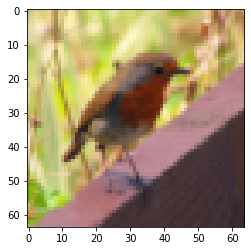

In [18]:
# Example of a picture
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [19]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [20]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


learning_rate:0.0075
minibatch_size:32
num_epochs:500
lambd:0.0
beta1:0
beta2:0
epsilon:0
L:4
m:209
n_x:12288
n_y:1
Init
(20, 12288)
(20, 1)
Init
(7, 20)
(7, 1)
Init
(5, 7)
(5, 1)
Init
(1, 5)
(1, 1)
loss_value: tf.Tensor(1.3554176915599139, shape=(), dtype=float64)
loss_value: tf.Tensor(0.8994528387482414, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6919389393262337, shape=(), dtype=float64)
loss_value: tf.Tensor(0.691126876338408, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6903148755572759, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6918769863688516, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6944696680898932, shape=(), dtype=float64)
Cost after epoch 0: 0.816371
loss_value: tf.Tensor(0.6936017876923789, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6906481103434217, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6912707885636044, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6911278287911748, shape=(), dtype=float64)
loss_value: tf.Tensor(0.690985563461

loss_value: tf.Tensor(0.671323002586805, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6711904727593561, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6761353867335069, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6607572867828637, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7068624951028446, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6337938540134905, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6966446115157574, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6757577408068375, shape=(), dtype=float64)
loss_value: tf.Tensor(0.670446587063209, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6650401154193772, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6541873804065521, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6429921183775307, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7021184299094599, shape=(), dtype=float64)
loss_value: tf.Tensor(0.68604628659245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6424221888676487, shape=(), dtype=float64)

loss_value: tf.Tensor(0.6403816251902481, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6129665579040535, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6580983619984685, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6580287087147734, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7039271125987451, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6396784754562272, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7300026164516077, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6855308238468765, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6763670322574044, shape=(), dtype=float64)
loss_value: tf.Tensor(0.658024118793656, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6303690357466553, shape=(), dtype=float64)
loss_value: tf.Tensor(0.67630916259292, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6577915937423475, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5905615873451004, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6387128770779642, shape=(), dtype=float64

loss_value: tf.Tensor(0.6396756388373499, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6395877521369082, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6275114832252808, shape=(), dtype=float64)
loss_value: tf.Tensor(0.651411986212956, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6634215193353252, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6875262977017598, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6549190074429316, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6151550656877272, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6270247331835908, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633241647523556, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6268352683659357, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6388817943399951, shape=(), dtype=float64)
loss_value: tf.Tensor(0.699937201691462, shape=(), dtype=float64)
loss_value: tf.Tensor(0.723590235960188, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6024725802366657, shape=(), dtype=float64

loss_value: tf.Tensor(0.6339776832913084, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6339165391885758, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6338556823782124, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6337951115205169, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6478540481160165, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7318041418263725, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6197213782738833, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6196017854326834, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6336405779612572, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6761279441580127, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6761246881002045, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6477796951918782, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6786329192138799, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6335920465897356, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6193305113788332, shape=(), dtype=floa

loss_value: tf.Tensor(0.6799602679740263, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6771925516210098, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6147623957658361, shape=(), dtype=float64)
loss_value: tf.Tensor(0.583392212920653, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6301955458985312, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7244085448216329, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6615736159000141, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6210157714219223, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6144804909803276, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6301133880583842, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6930670615521749, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6615698108699933, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7087595077481206, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6301716262928981, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5321036423191167, shape=(), dtype=float

loss_value: tf.Tensor(0.6616318309726454, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6114767092234406, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5552429745543528, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6784595940491307, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6784447677043165, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6112868936553666, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6112063455435002, shape=(), dtype=float64)
loss_value: tf.Tensor(0.644812680968059, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6279549262662352, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6815083147251797, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5942368694182854, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7123498758071041, shape=(), dtype=float64)
loss_value: tf.Tensor(0.627937355880569, shape=(), dtype=float64)
loss_value: tf.Tensor(0.611025134939836, shape=(), dtype=float64)
loss_value: tf.Tensor(0.67857817440666, shape=(), dtype=float64)


loss_value: tf.Tensor(0.6268025802250045, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6092321695622951, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6443015423398861, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494671933458197, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6618754606339743, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6618739274883629, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6091566061220646, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6266849154183054, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5914269228950637, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7501687163218338, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5832130126842112, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6971771850014246, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6795033185621067, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6090832455591109, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6442668905830391, shape=(), dtype=floa

loss_value: tf.Tensor(0.6257048556798048, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6804410621515189, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6439428625953012, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5892161861619802, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6622017929969064, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836948091166963, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5709198758610732, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6622143251977989, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6256224158595425, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7537664538373673, shape=(), dtype=float64)
loss_value: tf.Tensor(0.62568447697312, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6804626241609728, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5462419519103126, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6805314434769542, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6073268841366064, shape=(), dtype=float6

loss_value: tf.Tensor(0.6140703013740967, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6624633130927469, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6250475434839524, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5875890342134718, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6249816475150584, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7563437831120741, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6437518731022323, shape=(), dtype=float64)
loss_value: tf.Tensor(0.578805015065675, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6249839120934462, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6437322215940111, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7000425501684175, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6624830955669789, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6250070436285, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6624878056981023, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5434108595519241, shape=(), dtype=float64)

loss_value: tf.Tensor(0.5855319350903483, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6823343356730902, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6242111306318316, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6857418984416375, shape=(), dtype=float64)
Cost after epoch 200: 0.646849
loss_value: tf.Tensor(0.6435757150125113, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6048617988626929, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435708117222929, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6241885637299122, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6629624314841311, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7211130798218014, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5764361238831616, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6629543272636773, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6629474531465693, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435732186667413, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6048339

loss_value: tf.Tensor(0.6239139928364674, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7220490467304992, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6124238372610977, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623925964400053, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6042930825825978, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6828120190297245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6239091196926483, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6238955500584167, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6631739365042261, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7232314053923952, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6043440516488361, shape=(), dtype=float64)
loss_value: tf.Tensor(0.604295791408612, shape=(), dtype=float64)
loss_value: tf.Tensor(0.741731078210446, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5847682231721574, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7023979801975063, shape=(), dtype=float64

loss_value: tf.Tensor(0.7027879088083554, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435182050530891, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6040615046475435, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493246492779822, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435158745177397, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6830151204909143, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7421664267314292, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6828802018750548, shape=(), dtype=float64)
loss_value: tf.Tensor(0.525576319130553, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237957360287866, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5750264772604808, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237409775591245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7424324697408022, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237853114986729, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435163585450648, shape=(), dtype=float

loss_value: tf.Tensor(0.7423860931571951, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237957928988905, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493216760461965, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435175915464744, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6632512882629021, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237940715005499, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7224618412263383, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435218794667241, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5647362469899004, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493226367418022, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435170265763237, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435169022051702, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237766526892925, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237637156214257, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7225682236291056, shape=(), dtype=floa

loss_value: tf.Tensor(0.500453888674684, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633561829695329, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633473080555334, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633384773956347, shape=(), dtype=float64)
loss_value: tf.Tensor(0.663329690766592, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6236983979604613, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6236858346623069, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5746709576304245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7031201023015803, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7228710006955938, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5841118013998654, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633401089088597, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5443952934887635, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7031334001443791, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5372747497224182, shape=(), dtype=float6

loss_value: tf.Tensor(0.6234492086520433, shape=(), dtype=float64)
loss_value: tf.Tensor(0.762652454632044, shape=(), dtype=float64)
loss_value: tf.Tensor(0.643496808847881, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6235024062032946, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7435236133005716, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6235459192737196, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6634626521521838, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434989401588151, shape=(), dtype=float64)
loss_value: tf.Tensor(0.4991191586151569, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635271323419253, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623473630352718, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234621409643907, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434946300159676, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635389376350571, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434950101302425, shape=(), dtype=float64

loss_value: tf.Tensor(0.7236739409565538, shape=(), dtype=float64)
loss_value: tf.Tensor(0.683502205906953, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035328632436403, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6117253203310957, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6835380613371482, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6834976011697038, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5835577761563997, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5834593678451109, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7036278151694093, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635089657801333, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5740743339826557, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7637357680210042, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434976672398908, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434976373648602, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434976076357463, shape=(), dtype=float

loss_value: tf.Tensor(0.5630612783943167, shape=(), dtype=float64)
loss_value: tf.Tensor(0.611488272227349, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5628221029255474, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7041211997989354, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434916502583431, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636698056508479, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838269985068446, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5629057992398767, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7254354238604075, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6031997739291488, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7241614802544107, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6837426601461065, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7239095380118926, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836181855931718, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5633295548007464, shape=(), dtype=float

loss_value: tf.Tensor(0.5829309817085602, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7041476982586645, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636784890070215, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838443494289708, shape=(), dtype=float64)
loss_value: tf.Tensor(0.687359134034053, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7240214323241192, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635832729091056, shape=(), dtype=float64)
loss_value: tf.Tensor(0.56317405993724, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233698890436606, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233588960489012, shape=(), dtype=float64)
loss_value: tf.Tensor(0.703924181771908, shape=(), dtype=float64)
loss_value: tf.Tensor(0.573690582902088, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434919373403635, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7039406199589283, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6837283354845105, shape=(), dtype=float64)


loss_value: tf.Tensor(0.6636415540812199, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6873243961222625, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636087945388118, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233868117797148, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434924959547428, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6032585333526682, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636304740213534, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636202308602124, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494094085777686, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636072048904591, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7038056860485755, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234208370782726, shape=(), dtype=float64)
loss_value: tf.Tensor(0.703744446692165, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234420589447849, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5632410493202892, shape=(), dtype=float

loss_value: tf.Tensor(0.6636565383119641, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7241090347250085, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5831564205837246, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494167339349781, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233509628448003, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434919057034898, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233399236445225, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7039799001684174, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434922213288505, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636234454348855, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5736613160378305, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7241229717533257, shape=(), dtype=float64)
loss_value: tf.Tensor(0.703839151162577, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234092951814564, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434930077099742, shape=(), dtype=float

loss_value: tf.Tensor(0.6635403765942304, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493877839169331, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234621173615214, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234506839111231, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7036590008271564, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434954463083038, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5834234090741952, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836065606710736, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493877238977239, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234623621377502, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234509275214526, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836036167323695, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623461116947393, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635394979347069, shape=(), dtype=float64)
loss_value: tf.Tensor(0.603425542143792, shape=(), dtype=float6

loss_value: tf.Tensor(0.6035006071494575, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234759527335392, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5362720120982487, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6033176832745399, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6837110969414707, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635814708931023, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635714728264246, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434937975902671, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234257186153026, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6116032886034479, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434929762745055, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7640712728596211, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434950496149932, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6034278691900464, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836045472492163, shape=(), dtype=floa

loss_value: tf.Tensor(0.6233481531515731, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5830280515403414, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838646224872418, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494227462483456, shape=(), dtype=float64)
loss_value: tf.Tensor(0.583004704194234, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434915720968457, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838801292949382, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434916863797171, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636648897805146, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434917807910672, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494220158796356, shape=(), dtype=float64)
loss_value: tf.Tensor(0.683811404079163, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5427984414163266, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6232997292870412, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434915554801692, shape=(), dtype=float6

loss_value: tf.Tensor(0.6434921774736376, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233584157405333, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6032029514281713, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7443210522965751, shape=(), dtype=float64)
loss_value: tf.Tensor(0.583153549634654, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6873369994007217, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636144930890078, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434926039303676, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6032686792553644, shape=(), dtype=float64)
loss_value: tf.Tensor(0.643492181093123, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636257244876709, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5428766763629311, shape=(), dtype=float64)
loss_value: tf.Tensor(0.8393203371502737, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635671878536202, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434939418370288, shape=(), dtype=float6

loss_value: tf.Tensor(0.6434938106612773, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7627193319574056, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6835065655188144, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035282904793535, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234900331055129, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5634267118858634, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623434028463226, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836356238200484, shape=(), dtype=float64)
loss_value: tf.Tensor(0.8003572246088255, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035626378600157, shape=(), dtype=float64)
loss_value: tf.Tensor(0.643497026039593, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434969992995864, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035158558392617, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7035326471179539, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6235164745004056, shape=(), dtype=float6

loss_value: tf.Tensor(0.7231297730987126, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6236396186185186, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5838736828960821, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7828670438297769, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6038352474535368, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6037893716507879, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5370868935517515, shape=(), dtype=float64)


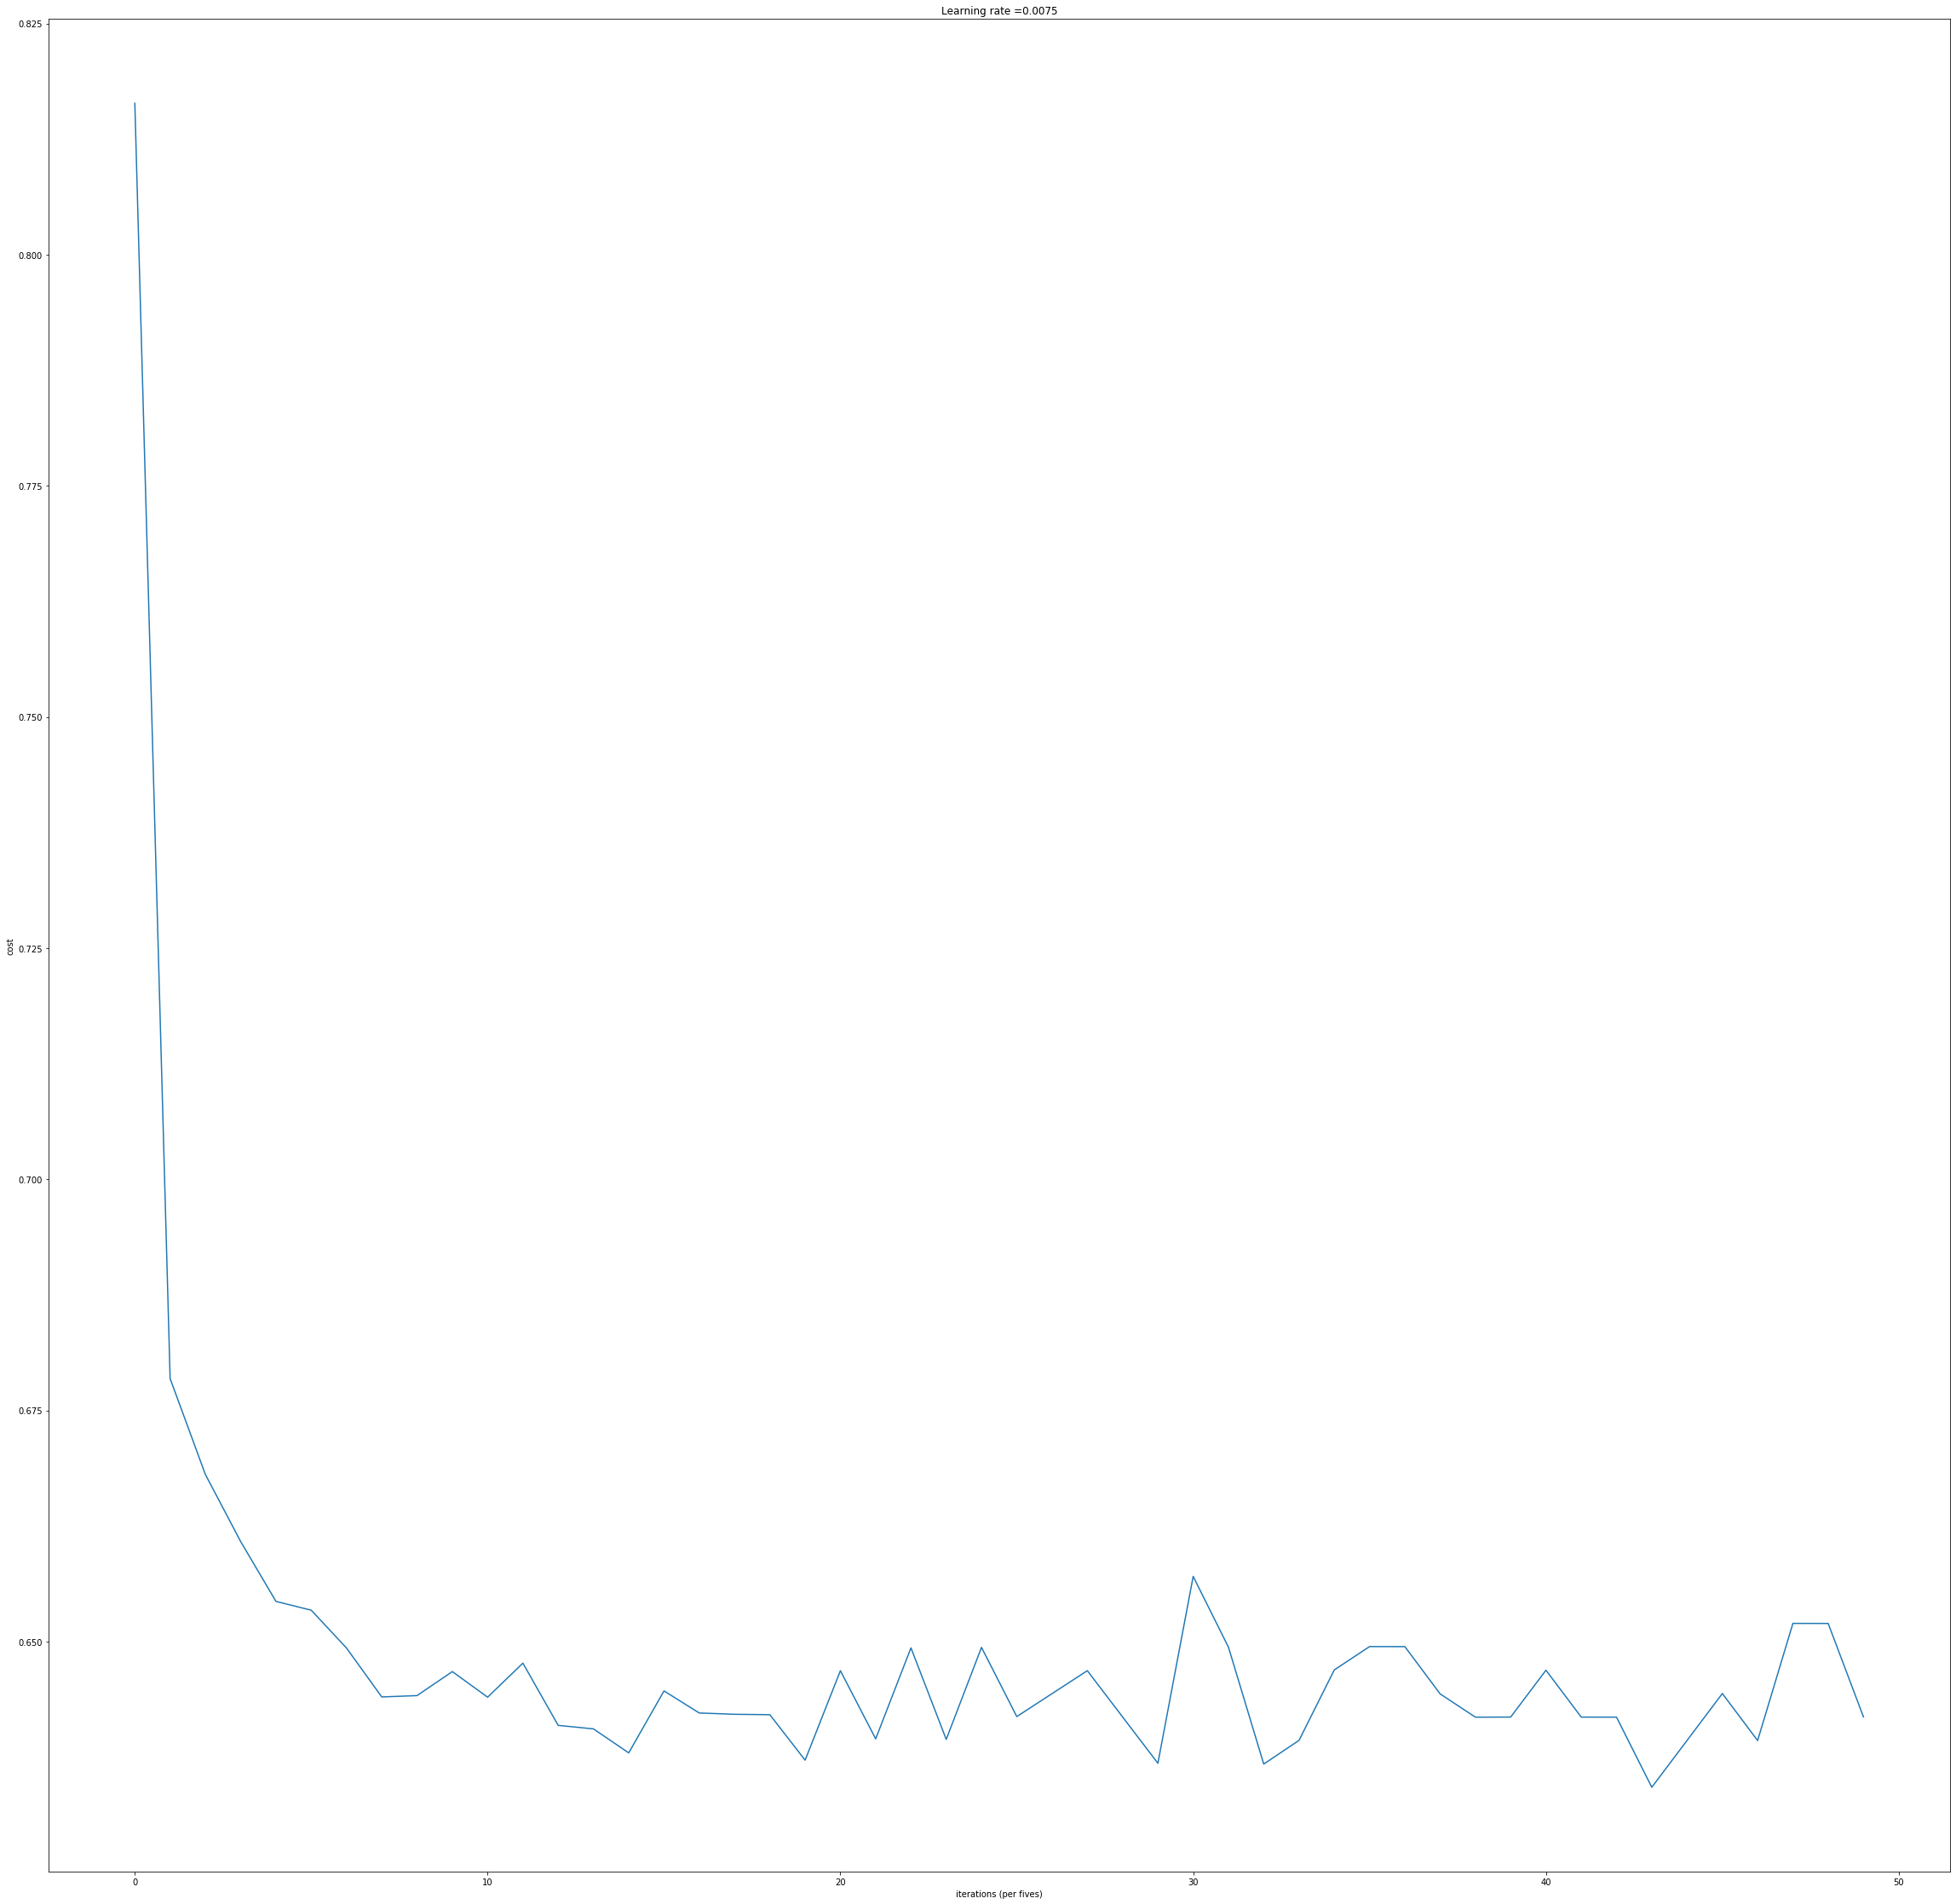

In [121]:
np.set_printoptions(precision=15)
listp = model_tf(train_x, train_y, layers_dims, learning_rate = 0.0075, num_epochs = 500, minibatch_size = 32, print_cost = True, lambd = 0., ADAM = False)

learning_rate:0.0075
minibatch_size:32
num_epochs:500
lambd:0.0
beta1:0
beta2:0
epsilon:0
L:4
m:209
n_x:12288
n_y:1
Init
(20, 12288)
(20, 1)
Init
(7, 20)
(7, 1)
Init
(5, 7)
(5, 1)
Init
(1, 5)
(1, 1)
loss_value: tf.Tensor(1.3554176915599139, shape=(), dtype=float64)
loss_value: tf.Tensor(0.8994528387482414, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6919389393262337, shape=(), dtype=float64)
loss_value: tf.Tensor(0.691126876338408, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6903148755572759, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6918769863688516, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6944696680898932, shape=(), dtype=float64)
Cost after epoch 0: 0.816371
loss_value: tf.Tensor(0.6936017876923789, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6906481103434217, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6912707885636044, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6911278287911748, shape=(), dtype=float64)
loss_value: tf.Tensor(0.690985563461

loss_value: tf.Tensor(0.671323002586805, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6711904727593561, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6761353867335069, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6607572867828637, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7068624951028446, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6337938540134905, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6966446115157574, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6757577408068375, shape=(), dtype=float64)
loss_value: tf.Tensor(0.670446587063209, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6650401154193772, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6541873804065521, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6429921183775307, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7021184299094599, shape=(), dtype=float64)
loss_value: tf.Tensor(0.68604628659245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6424221888676487, shape=(), dtype=float64)

loss_value: tf.Tensor(0.6403816251902481, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6129665579040535, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6580983619984685, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6580287087147734, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7039271125987451, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6396784754562272, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7300026164516077, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6855308238468765, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6763670322574044, shape=(), dtype=float64)
loss_value: tf.Tensor(0.658024118793656, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6303690357466553, shape=(), dtype=float64)
loss_value: tf.Tensor(0.67630916259292, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6577915937423475, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5905615873451004, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6387128770779642, shape=(), dtype=float64

loss_value: tf.Tensor(0.6396756388373499, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6395877521369082, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6275114832252808, shape=(), dtype=float64)
loss_value: tf.Tensor(0.651411986212956, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6634215193353252, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6875262977017598, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6549190074429316, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6151550656877272, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6270247331835908, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633241647523556, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6268352683659357, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6388817943399951, shape=(), dtype=float64)
loss_value: tf.Tensor(0.699937201691462, shape=(), dtype=float64)
loss_value: tf.Tensor(0.723590235960188, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6024725802366657, shape=(), dtype=float64

loss_value: tf.Tensor(0.6339776832913084, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6339165391885758, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6338556823782124, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6337951115205169, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6478540481160165, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7318041418263725, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6197213782738833, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6196017854326834, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6336405779612572, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6761279441580127, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6761246881002045, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6477796951918782, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6786329192138799, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6335920465897356, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6193305113788332, shape=(), dtype=floa

loss_value: tf.Tensor(0.6799602679740263, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6771925516210098, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6147623957658361, shape=(), dtype=float64)
loss_value: tf.Tensor(0.583392212920653, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6301955458985312, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7244085448216329, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6615736159000141, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6210157714219223, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6144804909803276, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6301133880583842, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6930670615521749, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6615698108699933, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7087595077481206, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6301716262928981, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5321036423191167, shape=(), dtype=float

loss_value: tf.Tensor(0.6616318309726454, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6114767092234406, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5552429745543528, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6784595940491307, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6784447677043165, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6112868936553666, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6112063455435002, shape=(), dtype=float64)
loss_value: tf.Tensor(0.644812680968059, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6279549262662352, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6815083147251797, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5942368694182854, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7123498758071041, shape=(), dtype=float64)
loss_value: tf.Tensor(0.627937355880569, shape=(), dtype=float64)
loss_value: tf.Tensor(0.611025134939836, shape=(), dtype=float64)
loss_value: tf.Tensor(0.67857817440666, shape=(), dtype=float64)


loss_value: tf.Tensor(0.6268025802250045, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6092321695622951, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6443015423398861, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494671933458197, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6618754606339743, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6618739274883629, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6091566061220646, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6266849154183054, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5914269228950637, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7501687163218338, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5832130126842112, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6971771850014246, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6795033185621067, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6090832455591109, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6442668905830391, shape=(), dtype=floa

loss_value: tf.Tensor(0.6257048556798048, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6804410621515189, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6439428625953012, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5892161861619802, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6622017929969064, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836948091166963, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5709198758610732, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6622143251977989, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6256224158595425, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7537664538373673, shape=(), dtype=float64)
loss_value: tf.Tensor(0.62568447697312, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6804626241609728, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5462419519103126, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6805314434769542, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6073268841366064, shape=(), dtype=float6

loss_value: tf.Tensor(0.6140703013740967, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6624633130927469, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6250475434839524, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5875890342134718, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6249816475150584, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7563437831120741, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6437518731022323, shape=(), dtype=float64)
loss_value: tf.Tensor(0.578805015065675, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6249839120934462, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6437322215940111, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7000425501684175, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6624830955669789, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6250070436285, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6624878056981023, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5434108595519241, shape=(), dtype=float64)

loss_value: tf.Tensor(0.5855319350903483, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6823343356730902, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6242111306318316, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6857418984416375, shape=(), dtype=float64)
Cost after epoch 200: 0.646849
loss_value: tf.Tensor(0.6435757150125113, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6048617988626929, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435708117222929, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6241885637299122, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6629624314841311, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7211130798218014, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5764361238831616, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6629543272636773, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6629474531465693, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435732186667413, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6048339

loss_value: tf.Tensor(0.6239139928364674, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7220490467304992, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6124238372610977, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623925964400053, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6042930825825978, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6828120190297245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6239091196926483, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6238955500584167, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6631739365042261, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7232314053923952, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6043440516488361, shape=(), dtype=float64)
loss_value: tf.Tensor(0.604295791408612, shape=(), dtype=float64)
loss_value: tf.Tensor(0.741731078210446, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5847682231721574, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7023979801975063, shape=(), dtype=float64

loss_value: tf.Tensor(0.7027879088083554, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435182050530891, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6040615046475435, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493246492779822, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435158745177397, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6830151204909143, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7421664267314292, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6828802018750548, shape=(), dtype=float64)
loss_value: tf.Tensor(0.525576319130553, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237957360287866, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5750264772604808, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237409775591245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7424324697408022, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237853114986729, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435163585450648, shape=(), dtype=float

loss_value: tf.Tensor(0.7423860931571951, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237957928988905, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493216760461965, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435175915464744, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6632512882629021, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237940715005499, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7224618412263383, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435218794667241, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5647362469899004, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493226367418022, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435170265763237, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6435169022051702, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237766526892925, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6237637156214257, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7225682236291056, shape=(), dtype=floa

loss_value: tf.Tensor(0.500453888674684, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633561829695329, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633473080555334, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633384773956347, shape=(), dtype=float64)
loss_value: tf.Tensor(0.663329690766592, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6236983979604613, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6236858346623069, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5746709576304245, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7031201023015803, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7228710006955938, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5841118013998654, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6633401089088597, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5443952934887635, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7031334001443791, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5372747497224182, shape=(), dtype=float6

loss_value: tf.Tensor(0.6234492086520433, shape=(), dtype=float64)
loss_value: tf.Tensor(0.762652454632044, shape=(), dtype=float64)
loss_value: tf.Tensor(0.643496808847881, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6235024062032946, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7435236133005716, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6235459192737196, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6634626521521838, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434989401588151, shape=(), dtype=float64)
loss_value: tf.Tensor(0.4991191586151569, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635271323419253, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623473630352718, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234621409643907, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434946300159676, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635389376350571, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434950101302425, shape=(), dtype=float64

loss_value: tf.Tensor(0.7236739409565538, shape=(), dtype=float64)
loss_value: tf.Tensor(0.683502205906953, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035328632436403, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6117253203310957, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6835380613371482, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6834976011697038, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5835577761563997, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5834593678451109, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7036278151694093, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635089657801333, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5740743339826557, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7637357680210042, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434976672398908, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434976373648602, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434976076357463, shape=(), dtype=float

loss_value: tf.Tensor(0.5630612783943167, shape=(), dtype=float64)
loss_value: tf.Tensor(0.611488272227349, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5628221029255474, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7041211997989354, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434916502583431, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636698056508479, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838269985068446, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5629057992398767, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7254354238604075, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6031997739291488, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7241614802544107, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6837426601461065, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7239095380118926, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836181855931718, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5633295548007464, shape=(), dtype=float

loss_value: tf.Tensor(0.5829309817085602, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7041476982586645, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636784890070215, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838443494289708, shape=(), dtype=float64)
loss_value: tf.Tensor(0.687359134034053, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7240214323241192, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635832729091056, shape=(), dtype=float64)
loss_value: tf.Tensor(0.56317405993724, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233698890436606, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233588960489012, shape=(), dtype=float64)
loss_value: tf.Tensor(0.703924181771908, shape=(), dtype=float64)
loss_value: tf.Tensor(0.573690582902088, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434919373403635, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7039406199589283, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6837283354845105, shape=(), dtype=float64)


loss_value: tf.Tensor(0.6636415540812199, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6873243961222625, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636087945388118, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233868117797148, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434924959547428, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6032585333526682, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636304740213534, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636202308602124, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494094085777686, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636072048904591, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7038056860485755, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234208370782726, shape=(), dtype=float64)
loss_value: tf.Tensor(0.703744446692165, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234420589447849, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5632410493202892, shape=(), dtype=float

loss_value: tf.Tensor(0.6636565383119641, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7241090347250085, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5831564205837246, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494167339349781, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233509628448003, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434919057034898, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233399236445225, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7039799001684174, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434922213288505, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636234454348855, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5736613160378305, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7241229717533257, shape=(), dtype=float64)
loss_value: tf.Tensor(0.703839151162577, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234092951814564, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434930077099742, shape=(), dtype=float

loss_value: tf.Tensor(0.6635403765942304, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493877839169331, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234621173615214, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234506839111231, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7036590008271564, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434954463083038, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5834234090741952, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836065606710736, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6493877238977239, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234623621377502, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234509275214526, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836036167323695, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623461116947393, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635394979347069, shape=(), dtype=float64)
loss_value: tf.Tensor(0.603425542143792, shape=(), dtype=float6

loss_value: tf.Tensor(0.6035006071494575, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234759527335392, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5362720120982487, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6033176832745399, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6837110969414707, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635814708931023, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635714728264246, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434937975902671, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234257186153026, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6116032886034479, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434929762745055, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7640712728596211, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434950496149932, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6034278691900464, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836045472492163, shape=(), dtype=floa

loss_value: tf.Tensor(0.6233481531515731, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5830280515403414, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838646224872418, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494227462483456, shape=(), dtype=float64)
loss_value: tf.Tensor(0.583004704194234, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434915720968457, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6838801292949382, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434916863797171, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636648897805146, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434917807910672, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6494220158796356, shape=(), dtype=float64)
loss_value: tf.Tensor(0.683811404079163, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5427984414163266, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6232997292870412, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434915554801692, shape=(), dtype=float6

loss_value: tf.Tensor(0.6434921774736376, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6233584157405333, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6032029514281713, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7443210522965751, shape=(), dtype=float64)
loss_value: tf.Tensor(0.583153549634654, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6873369994007217, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636144930890078, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434926039303676, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6032686792553644, shape=(), dtype=float64)
loss_value: tf.Tensor(0.643492181093123, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6636257244876709, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5428766763629311, shape=(), dtype=float64)
loss_value: tf.Tensor(0.8393203371502737, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6635671878536202, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434939418370288, shape=(), dtype=float6

loss_value: tf.Tensor(0.6434938106612773, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7627193319574056, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6835065655188144, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035282904793535, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6234900331055129, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5634267118858634, shape=(), dtype=float64)
loss_value: tf.Tensor(0.623434028463226, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6836356238200484, shape=(), dtype=float64)
loss_value: tf.Tensor(0.8003572246088255, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035626378600157, shape=(), dtype=float64)
loss_value: tf.Tensor(0.643497026039593, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6434969992995864, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6035158558392617, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7035326471179539, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6235164745004056, shape=(), dtype=float6

loss_value: tf.Tensor(0.7231297730987126, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6236396186185186, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5838736828960821, shape=(), dtype=float64)
loss_value: tf.Tensor(0.7828670438297769, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6038352474535368, shape=(), dtype=float64)
loss_value: tf.Tensor(0.6037893716507879, shape=(), dtype=float64)
loss_value: tf.Tensor(0.5370868935517515, shape=(), dtype=float64)


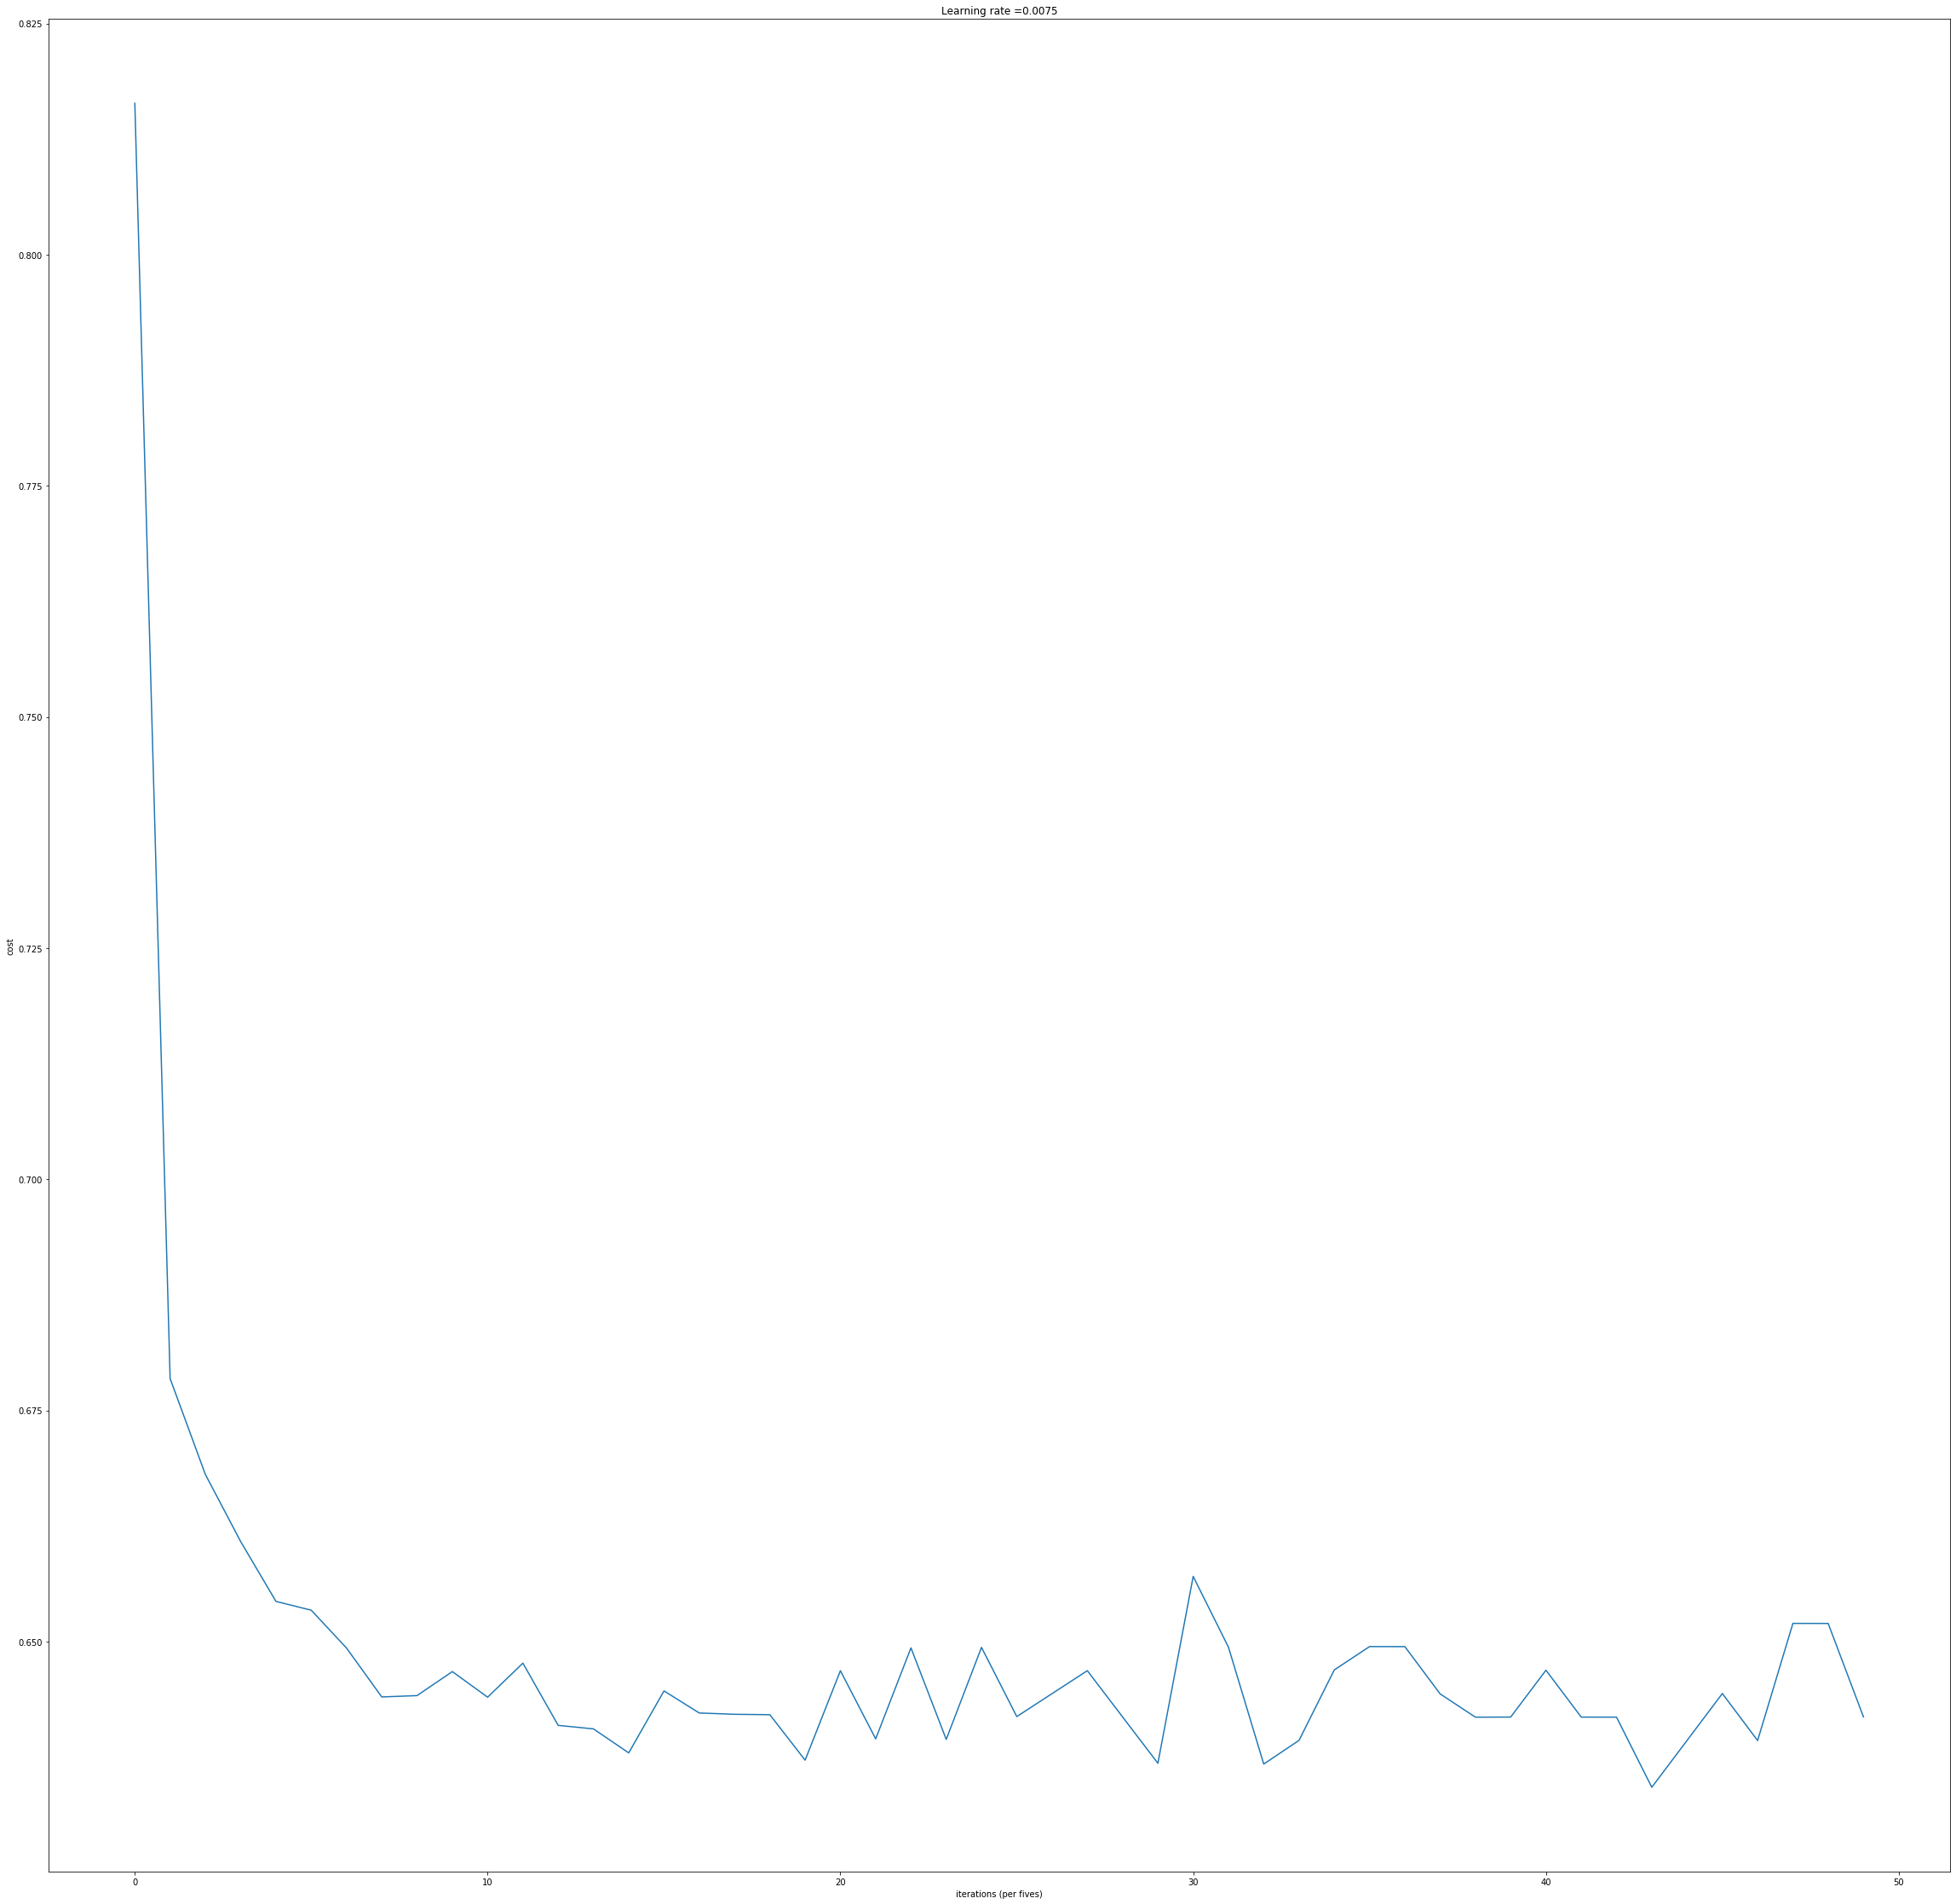

In [ ]:
learning_rate:0.0075
minibatch_size:32
num_epochs:1500
lambd:0.0
beta1:0
beta2:0
epsilon:0
L:4
m:209
n_x:12288
n_y:1
Init
(20, 12288)
(20, 1)
Init
(7, 20)
(7, 1)
Init
(5, 7)
(5, 1)
Init
(1, 5)
(1, 1)
Cost after epoch 0: 0.792810
Cost after epoch 50: 0.653417
Cost after epoch 100: 0.631430
Cost after epoch 150: 0.624750
Cost after epoch 200: 0.601067
Cost after epoch 250: 0.567795
Cost after epoch 300: 0.419093
Cost after epoch 350: 0.210865
Cost after epoch 400: 0.123477
Cost after epoch 450: 0.066791
Cost after epoch 500: 0.046529
Cost after epoch 550: 0.039209
Cost after epoch 600: 0.034645
Cost after epoch 650: 0.032059
Cost after epoch 700: 0.030750
Cost after epoch 750: 0.045402
Cost after epoch 800: 0.026522
Cost after epoch 850: 0.024006
Cost after epoch 900: 0.021874
Cost after epoch 950: 0.020881
Cost after epoch 1000: 0.020103
Cost after epoch 1050: 0.019664
Cost after epoch 1100: 0.019179
Cost after epoch 1150: 0.018831
Cost after epoch 1200: 0.018445
Cost after epoch 1250: 0.018216
Cost after epoch 1300: 0.017792
Cost after epoch 1350: 0.032211
Cost after epoch 1400: 0.017235
Cost after epoch 1450: 0.016788

In [ ]:
learning_rate:0.0075
minibatch_size:32
num_epochs:1500
lambd:0.0
beta1:0.9
beta2:0.999
epsilon:0.0001
L:4
m:209
n_x:12288
n_y:1
Init
(20, 12288)
(20, 1)
Init
(7, 20)
(7, 1)
Init
(5, 7)
(5, 1)
Init
(1, 5)
(1, 1)
Cost after epoch 0: 1.145657
Cost after epoch 50: 0.649536
Cost after epoch 100: 0.639293
Cost after epoch 150: 0.646941
Cost after epoch 200: 0.646947
Cost after epoch 250: 0.647067
Cost after epoch 300: 0.646901
Cost after epoch 350: 0.646919
Cost after epoch 400: 0.639478
Cost after epoch 450: 0.639221
Cost after epoch 500: 0.644431
Cost after epoch 550: 0.639274
Cost after epoch 600: 0.644380
Cost after epoch 650: 0.646920
Cost after epoch 700: 0.636724
Cost after epoch 750: 0.652043
Cost after epoch 800: 0.647044
Cost after epoch 850: 0.649565
Cost after epoch 900: 0.639686
Cost after epoch 950: 0.641935
Cost after epoch 1000: 0.644363
Cost after epoch 1050: 0.646917
Cost after epoch 1100: 0.644398
Cost after epoch 1150: 0.646897
Cost after epoch 1200: 0.641790
Cost after epoch 1250: 0.646960
Cost after epoch 1300: 0.639380
Cost after epoch 1350: 0.646967
Cost after epoch 1400: 0.644359
Cost after epoch 1450: 0.636760

In [ ]:
earning_rate:0.0075
minibatch_size:32
num_epochs:1500
lambd:0.0
L:4
m:209
n_x:12288
n_y:1
Init
(20, 12288)
(20, 1)
Init
(7, 20)
(7, 1)
Init
(5, 7)
(5, 1)
Init
(1, 5)
(1, 1)
Cost after epoch 0: 1.022165
Cost after epoch 50: 0.648617
Cost after epoch 100: 0.616246
Cost after epoch 150: 0.587601
Cost after epoch 200: 0.521900
Cost after epoch 250: 0.471566
Cost after epoch 300: 0.394092
Cost after epoch 350: 0.261284
Cost after epoch 400: 0.112829
Cost after epoch 450: 0.079025
Cost after epoch 500: 0.058917
Cost after epoch 550: 0.054299
Cost after epoch 600: 0.051322
Cost after epoch 650: 0.049924
Cost after epoch 700: 0.049445
Cost after epoch 750: 0.064124
Cost after epoch 800: 0.048230
Cost after epoch 850: 0.047503
Cost after epoch 900: 0.063448
Cost after epoch 950: 0.044173
Cost after epoch 1000: 0.039842
Cost after epoch 1050: 0.037582
Cost after epoch 1100: 0.036215
Cost after epoch 1150: 0.034707
Cost after epoch 1200: 0.032481
Cost after epoch 1250: 0.031531
Cost after epoch 1300: 0.029928
Cost after epoch 1350: 0.041627
Cost after epoch 1400: 0.027720
Cost after epoch 1450: 0.026471

In [122]:
def predict_tf(X, y, listp):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    L = len(layers_dims) -1            # number of layers in the network
    print ("L : " + str(L))
    
    m = X.shape[1]
    p = np.zeros((1,m))
    
    # Forward propagation
    PAL = L_model_forward_list(L, X, listp)

    
    # convert probas to 0/1 predictions
    for i in range(0, PAL.shape[1]):
        if PAL[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    print ("predictions: " + str(p))
    print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [123]:
pred_train = predict_tf(train_x, train_y, listp)

L : 4
predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
true labels: [[0 0 1 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0
  0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 1
  0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 1 1
  1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0
  1 1 1 0 1 1 0 0 0 1 0 0

In [124]:
pred_test = predict_tf(test_x, test_y, listp)     

L : 4
predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0.]]
true labels: [[1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0 0
  0 1 0 0 1 1 1 0 0 0 1 1 1 0]]
Accuracy: 0.3400000000000001


In [77]:
def print_mislabeled_images_new(classes, X, y, p):
    """
    Plots images where predictions and truth were different.
    X -- dataset
    y -- true labels
    p -- predictions
    """
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))


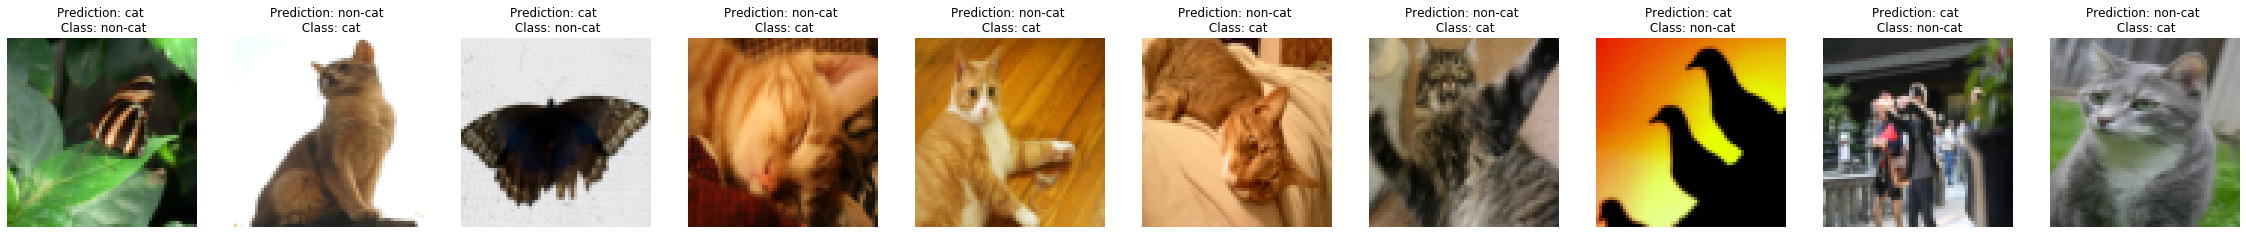

In [78]:
print_mislabeled_images_new(classes, test_x, test_y, pred_test)

original shape:  (1000, 1500, 3)
new shape:  (12288, 1)
L : 4
predictions: [[0.]]
true labels: [1]
Accuracy: 0.0
y = 0.0, your L-layer model predicts a "non-cat" picture.


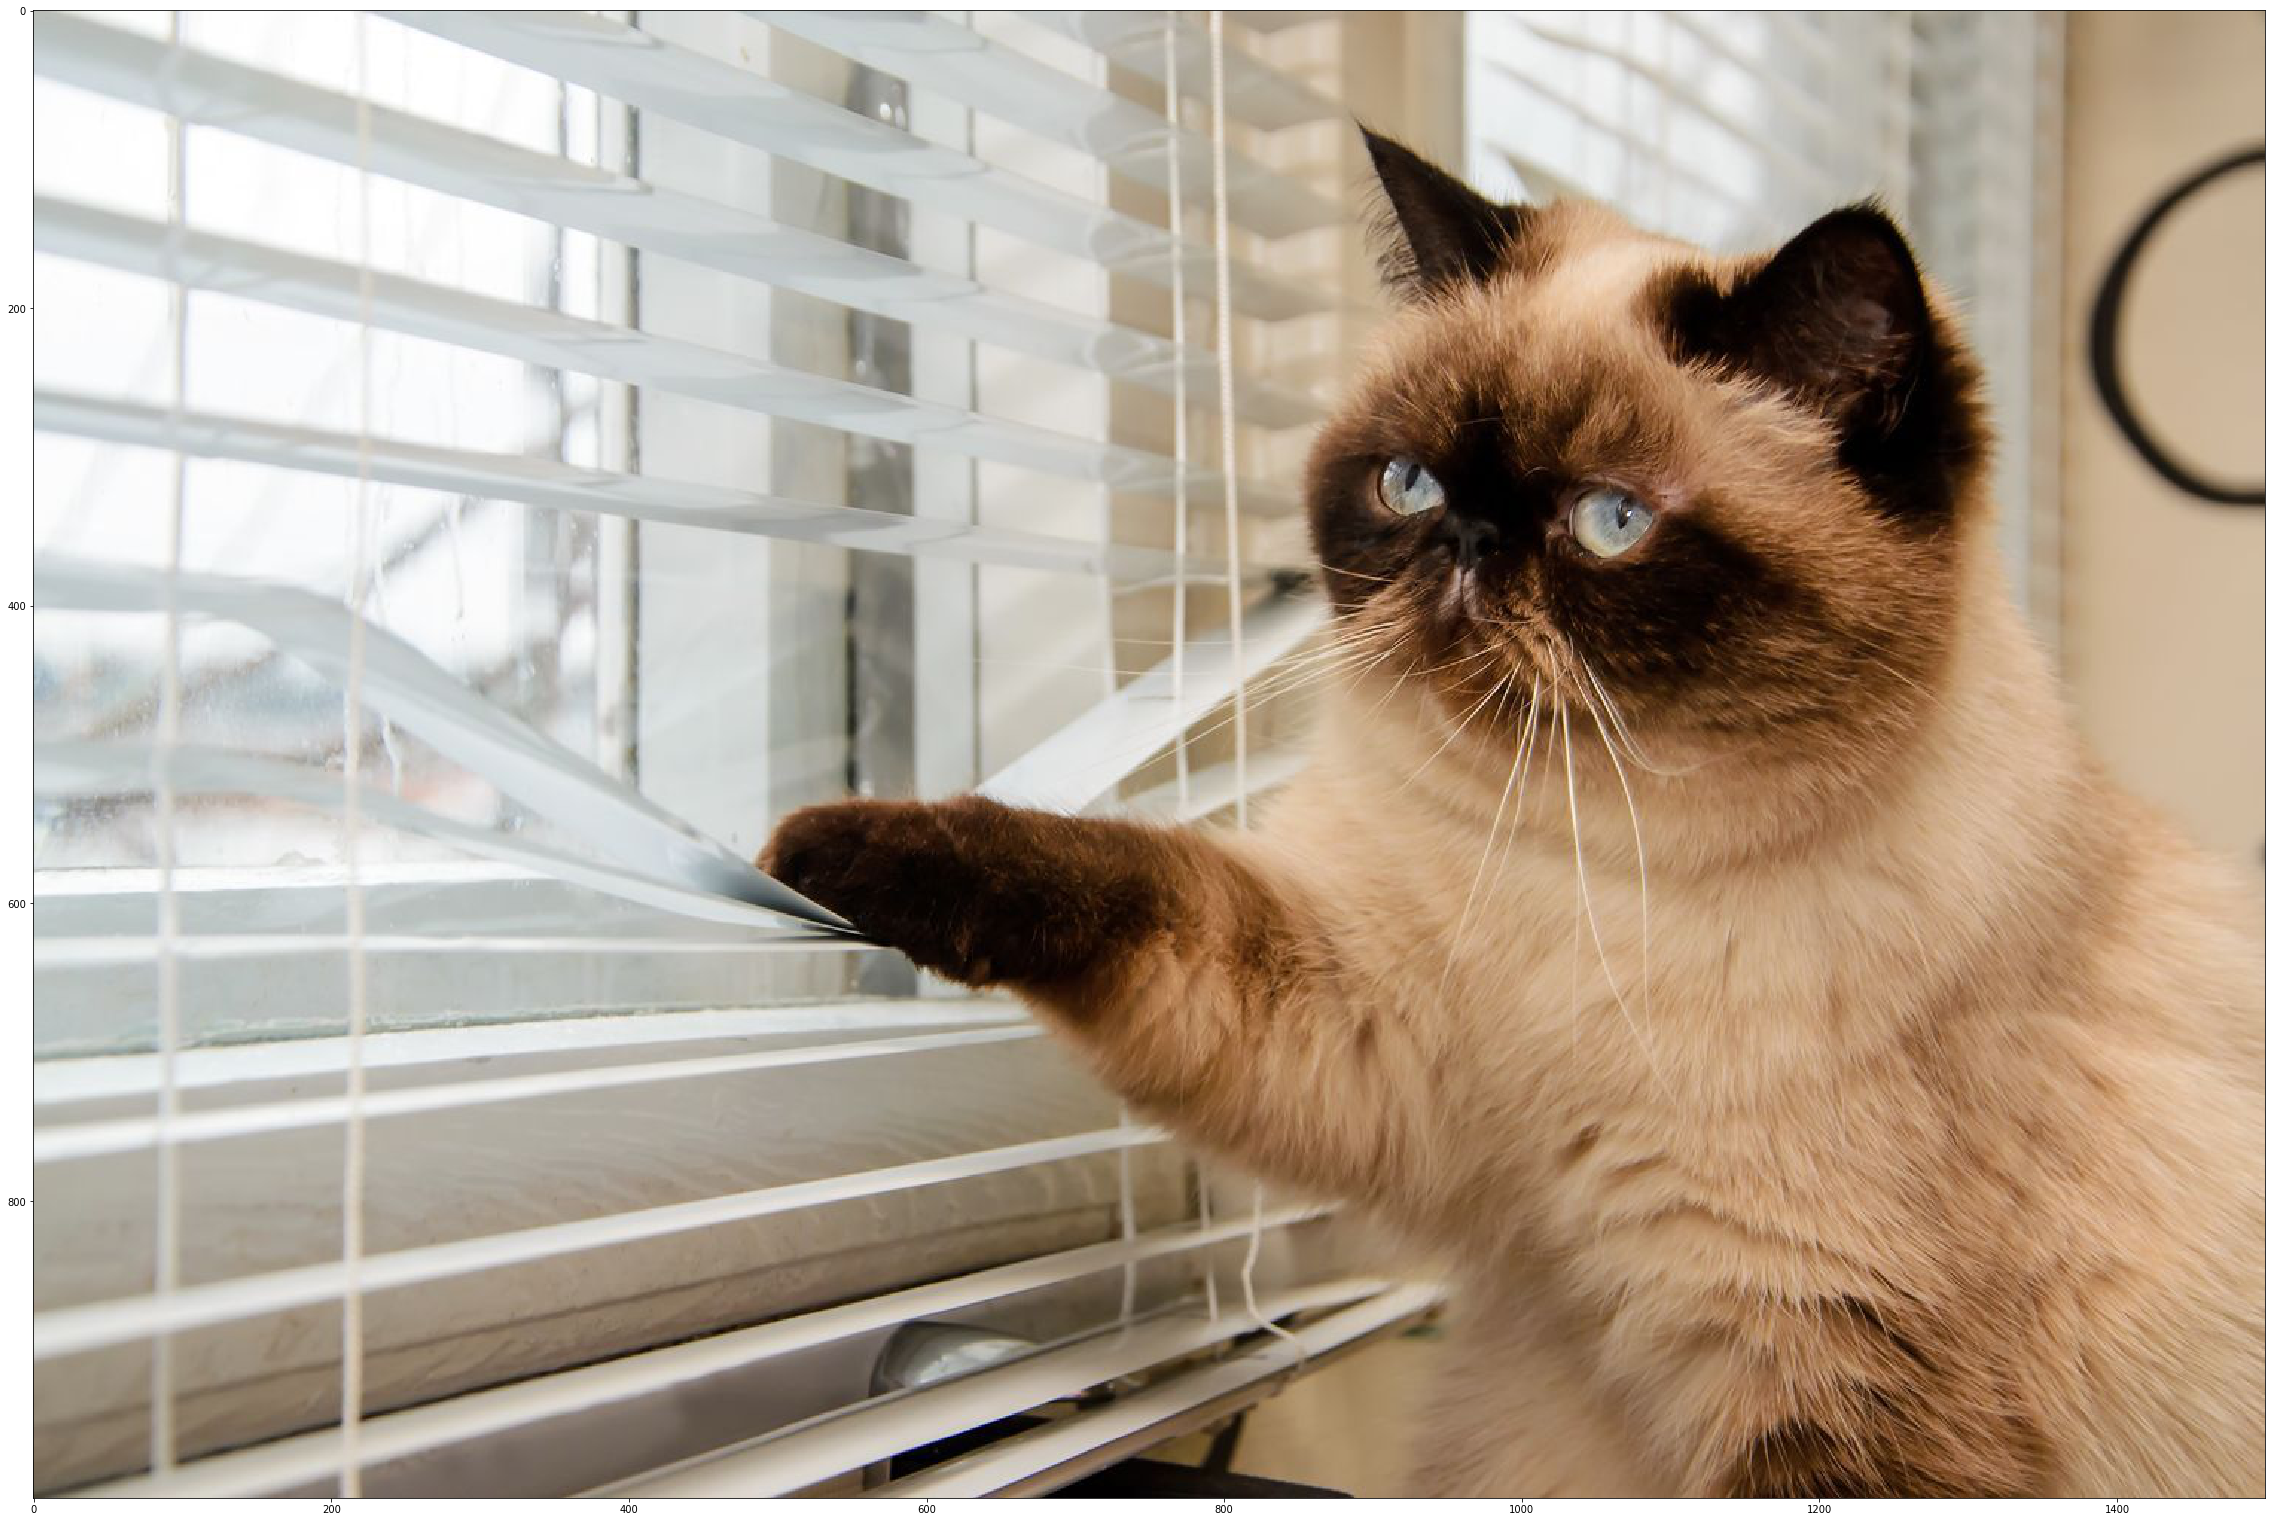

In [82]:
import imageio
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

my_image = "chat1.jpg" # change this to the name of your image file 
my_label_y = [1] # the true class of your image (1 -> cat, 0 -> non-cat)
fname = "images/" + my_image
im = imageio.imread(fname, as_gray=False)
print("original shape: " , im.shape)

image_resized = resize(im, (64, 64),preserve_range=True).reshape((64*64*3,1))
image_resized = image_resized/255.
print("new shape: ", image_resized.shape)

my_predicted_image = predict_tf(image_resized, my_label_y, listp)

plt.imshow(im)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")